# CISC/CMPE 452/COGS 400 Assignment 2 - Backpropagation (15 points)  

Please put your name and student id here

    Ilir Gusija, #20158525

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs. You will only get credit for code that has been run.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)


## [Part 1 (9 points)](#Part-1)  

### Build Model1 (7 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (1 point)  
- 2. Calculate errors and loss (3 points)  
- 3. Update the weights with backpropagation (1 points)  
- 4. Predict function (1 point)  
- 5. Activation function (Sigmoid function) (1 point)  

### Evaluator Function (1 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate Model1 (1 point)  
Train Model1 with customized hidden size, learning rate, number of iterations and batch size  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (6 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (2 points)  
Implement Model2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-1 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (2 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-2 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

In [43]:
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import numpy as np
import datetime

In [44]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [45]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [46]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


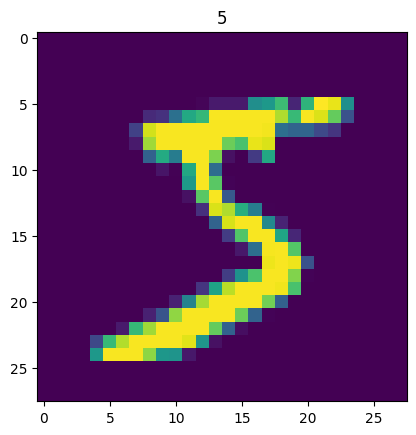

In [47]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [77]:
import numpy as np

def evaluator(y_test, y_pred):
    # Number of classes is 10 for MNIST
    num_classes = 10
    
    # Initialize confusion matrix with zeros
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)
    
    # Fill up the confusion matrix
    for y_t, y_p in zip(y_test, y_pred):
        conf_mat[y_t][y_p] += 1

    # Print confusion matrix
    print("Confusion Matrix:\n", conf_mat)

    # Compute overall accuracy
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    print("Overall Accuracy: ", accuracy)

    # Compute micro-averaged precision, recall, F1-score
    TP = np.trace(conf_mat)
    FP = np.sum(np.sum(conf_mat, axis=0) - np.diag(conf_mat))
    FN = np.sum(np.sum(conf_mat, axis=1) - np.diag(conf_mat))
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
        
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-Score: ", f1)

####################################################################################################

## Part 1

In [99]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, dtype=np.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        return 1/(1+np.exp(-x))
        
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = np.random.randn(input_size, self.hidden_size).astype(self.dtype) * 0.01
        self.W2 = np.random.randn(self.hidden_size, num_classes).astype(self.dtype) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output
                hidden = self.sigmoid(np.matmul(x_batch, self.W1))
                output = self.sigmoid(np.matmul(hidden, self.W2))
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden
                output_error = y_batch - output
                loss += np.average(np.square(output_error))
                delta_output = output_error * output * (1 - output)
                delta_hidden = np.matmul(delta_output, self.W2.T) * hidden * (1 - hidden)
                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                dw2 = self.learning_rate * np.dot(hidden.T, delta_output)
                dw1 = self.learning_rate * np.dot(x_batch.T, delta_hidden)
                
                self.W2 += dw2
                self.W1 += dw1                
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = np.sum(np.argmax(y, axis=1) == y_pred) 
            # print("Train correct", train_acc, " total: ", n_train)
            train_acc /= n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            print()
            val_acc = np.sum(np.argmax(y_val, axis=1) == y_pred)
            # print("Val correct", val_acc, " total: ", n_val)
            val_acc /= n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        hidden = self.sigmoid(np.dot(x, self.W1))
        y_pred = self.sigmoid(np.dot(hidden, self.W2))
        y_pred = np.argmax(y_pred, axis=1)
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [100]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))
model = NN(learning_rate=0.01, n_iters=10, batch_size=64, hidden_size=200)

x_train = data_dict['x_train'].numpy()
x_test = data_dict['x_test'].numpy()
x_val = data_dict['x_val'].numpy()
y_train = data_dict['y_train'].numpy()
y_train_torch = data_dict['y_train']
y_test = data_dict['y_test'].numpy()
y_val = data_dict['y_val'].numpy()

model.train(x_train, y_train, x_val, y_val)

####################################################################################################


epoch 1, loss 51.4664, train acc 0.841, validation acc 0.857

epoch 2, loss 20.9204, train acc 0.888, validation acc 0.901

epoch 3, loss 15.6405, train acc 0.902, validation acc 0.913

epoch 4, loss 13.6370, train acc 0.910, validation acc 0.920

epoch 5, loss 12.4197, train acc 0.916, validation acc 0.924

epoch 6, loss 11.5301, train acc 0.921, validation acc 0.927

epoch 7, loss 10.8190, train acc 0.926, validation acc 0.931

epoch 8, loss 10.2204, train acc 0.929, validation acc 0.934

epoch 9, loss 9.6977, train acc 0.933, validation acc 0.938

epoch 10, loss 9.2279, train acc 0.935, validation acc 0.941


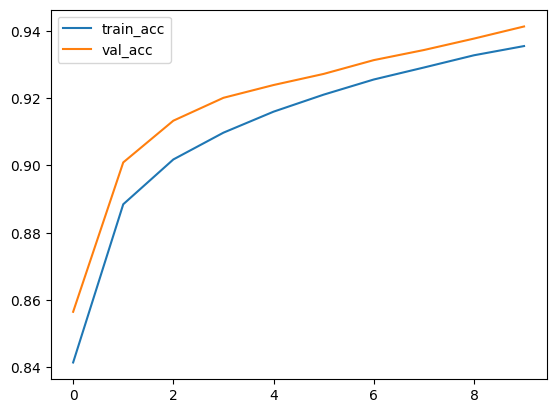

In [101]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [102]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator
y_pred = model.predict(x_test)
evaluator(np.argmax(y_test, axis=1), y_pred)
####################################################################################################

Confusion Matrix:
 [[ 962    0    1    1    0    2   10    1    3    0]
 [   0 1111    3    3    0    2    4    2   10    0]
 [  10    0  945    8    8    4   16   15   20    6]
 [   1    1   17  936    1   21    3   11   16    3]
 [   2    5    4    1  902    1   15    3    8   41]
 [   8    3    1   30    6  795   16    5   20    8]
 [  11    3    4    0    5   10  921    0    4    0]
 [   3    8   24    4    7    1    0  962    2   17]
 [   9    5    3   13    6   17    9    8  902    2]
 [  11    7    0   12   23    9    1    9    7  930]]
Overall Accuracy:  0.9366
Precision:  0.9366
Recall:  0.9366
F1-Score:  0.9366


## Part 2

### Model2-1

In [103]:
####################################################################################################
# enter code here to implement Model2-1
class NN2(torch.nn.Module):
    def __init__(self, hidden_size=200):
        super(NN2, self).__init__()
        self.fc1 = torch.nn.Linear(784, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, 10)
        
    def forward(self, X):
        ####################################################################################################
        X = self.fc1(X)
        X = F.sigmoid(X)
        X = self.fc2(X)
        X = F.sigmoid(X)
        ###################################################################################################
        return X
        
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

def train(n_epochs, model, loss_fn, opt, train_loader, val_loader, device):
    model.to(device)
    model.train()
    losses_train = []
    
    for epoch in range(1, n_epochs+1):
        print('epoch ', epoch)
        loss_train = 0.0
        for x_batch, y_batch in train_loader:
            # compute output
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch.float())

            # compute gradient and do SGD step
            opt.zero_grad()
            loss.backward()
            loss_train += loss.item()
            opt.step()

        # calculate the accuracy and save the training history
        losses_train += [loss_train/len(train_loader)]
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation to run accuracy analytics w/o adjusting parameters
            for data, targets in train_loader:
                data = data.view(data.size(0), -1)
                data = data.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)  # Get the predicted classes
                total += targets.size(0)
                correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
            # print("Train correct: ", correct, " Total: ", total)
            train_acc = correct / total
            correct = 0
            total = 0
            for data, targets in val_loader:
                data = data.view(data.size(0), -1)
                data = data.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)  # Get the predicted classes
                total += targets.size(0)
                correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
            # print("Val correct: ", correct, " Total: ", total)
            val_acc = correct / total
            print('{} Epoch {}, Training loss {}, train acc {}, validation acc {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader), train_acc, val_acc))
        model.train()

    return losses_train   
####################################################################################################

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 200]              157,000
├─Linear: 1-2                            [-1, 1, 10]               2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61
epoch  1
2023-10-11 13:08:36.625130 Epoch 1, Training loss 0.09183205351652697, train acc 0.12832, validation acc 0.1197
epoch  2
2023-10-11 13:08:47.047741 Epoch 2, Training loss 0.08870264097971989, train acc 0.27664, validation acc 0.2712
epoch  3
2023-10-11 13:08:57.020249 Epoch 3, Training loss 0.08748939140792698, train acc 0.3063, validation acc 0.3072
epoch  4
2023-10-11 13:09:04.427040 Epoch 4, Training loss 0.0856047415786692, train acc 0.35204, validation acc 0.3558
epoch  5
2023-10-11 13:09:10.830410 Epoch 5, Training loss 0.08255429959396267, tr

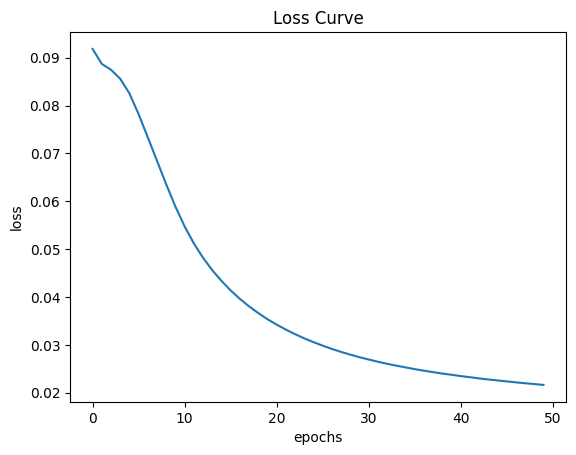

In [105]:
####################################################################################################
# enter code here to train Model2-1
batch_size=64

# Create custom datasets 
train_dataset = CustomDataset(data_dict['x_train'].to(device), data_dict['y_train'].to(device))
val_dataset = CustomDataset(data_dict['x_val'].to(device), data_dict['y_val'].to(device))

# Load datasets in dataloaders that allows us to use pytorch's built-in minibatching functionality
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)

# Initialize Model and hyperparameters
model1 = NN2()
loss = torch.nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

# Summarize model and data
summary(model1, (1, 28*28))

# Train model
losses_train = train(50, model1, loss, optimizer, train_loader, val_loader ,'cuda')

# Save model
torch.save(model1.state_dict(), 'NN2.pth')

# Plot loss curve
plt.plot(losses_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curve')
plt.savefig('loss.NN2.png')

####################################################################################################

In [106]:
####################################################################################################
# enter code here to evaluate Model2-1
x_test = data_dict['x_test'].to(device)
y_test = data_dict['y_test'].to(device)
with torch.no_grad():
    test_outputs = model1(x_test)
evaluator(torch.argmax(y_test, dim=1), torch.argmax(test_outputs, dim=1))
####################################################################################################

Confusion Matrix:
 [[ 960    0    1    1    2    3    8    1    4    0]
 [   0 1099    2    4    1    2    5    1   21    0]
 [  14    7  895   13   15    0   19   22   38    9]
 [   6    2   22  897    1   24    7   19   21   11]
 [   1    7    6    0  888    1   13    1    7   58]
 [  19    6    7   49   22  709   22   14   34   10]
 [  14    3    8    2    9   16  901    1    4    0]
 [   5   19   33    3   11    0    0  923    3   31]
 [  11   12   11   24   13   24   14   11  843   11]
 [  16    8   10   12   43   15    1   25    7  872]]
Overall Accuracy:  0.8987
Precision:  0.8987
Recall:  0.8987
F1-Score:  0.8987


### Model2-2

In [107]:
####################################################################################################
# enter code here to implement Model2-2
####################################################################################################
# enter code here to implement Model2-1
class NN3(torch.nn.Module):
    def __init__(self, hidden_size_1=512, hidden_size_2=256):
        super(NN3, self).__init__()
        self.fc1 = torch.nn.Linear(784, hidden_size_1)
        self.fc2 = torch.nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = torch.nn.Linear(hidden_size_2, 10)
        
    def forward(self, X):
        ####################################################################################################
        X = self.fc1(X)
        X = F.sigmoid(X)
        X = self.fc2(X)
        X = F.sigmoid(X)
        X = self.fc3(X)
        X = F.sigmoid(X)
        ###################################################################################################
        return X
####################################################################################################

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 512]              401,920
├─Linear: 1-2                            [-1, 1, 256]              131,328
├─Linear: 1-3                            [-1, 1, 10]               2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
Total mult-adds (M): 0.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.04
Estimated Total Size (MB): 2.05
epoch  1
2023-10-11 17:05:22.928286 Epoch 1, Training loss 0.09216452101269342, train acc 0.11356, validation acc 0.1064
epoch  2
2023-10-11 17:05:30.206253 Epoch 2, Training loss 0.08993514492879133, train acc 0.11356, validation acc 0.1064
epoch  3
2023-10-11 17:05:37.299607 Epoch 3, Training loss 0.08991038978404706, train acc 0.11356, validation acc 0.1064
epoch  4
2023-10-11 17:05:44.181734 Epoch 4, Training loss 0.08988755173466699, train acc 0.11356, validation acc 0.1064
epoch

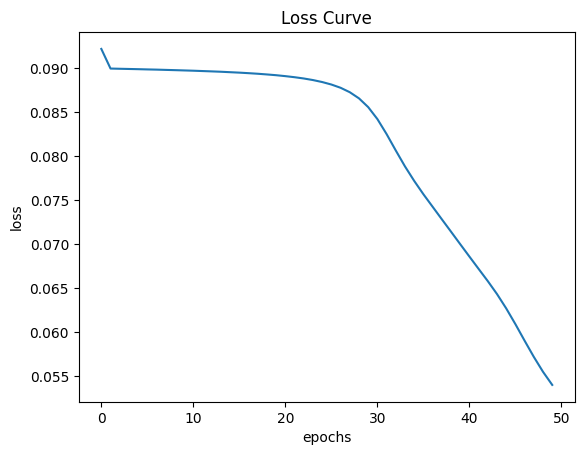

In [111]:
####################################################################################################
# enter code here to train Model2-2

# Create custom datasets 
train_dataset = CustomDataset(data_dict['x_train'].to(device), data_dict['y_train'].to(device))
val_dataset = CustomDataset(data_dict['x_val'].to(device), data_dict['y_val'].to(device))

# Load datasets in dataloaders that allows us to use pytorch's built-in minibatching functionality
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)

# Initialize Model and hyperparameters
model2 = NN3()
loss = torch.nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

# Summarize model and data
summary(model2, (1, 28*28))

# Train model
losses_train = train(50, model2, loss, optimizer, train_loader, val_loader ,'cuda')

# Save model
torch.save(model2.state_dict(), 'NN3.pth')

# Plot loss curve
plt.plot(losses_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curve')
plt.savefig('loss.NN3.png')

####################################################################################################

In [109]:
####################################################################################################
# enter code here to evaluate Model2-2
with torch.no_grad():
    test_outputs_2 = model2(x_test)
    evaluator(torch.argmax(y_test,dim=1), torch.argmax(test_outputs_2, dim=1))
####################################################################################################

Confusion Matrix:
 [[ 955    0    3    8    2    4    7    1    0    0]
 [   0 1123    3    6    0    0    1    1    1    0]
 [  44   73  508  150   25    1  210   18    3    0]
 [   9   15   22  916    3    0    4   36    3    2]
 [   1   23    3    1  825    0   46   42    0   41]
 [  73   13   50  474   17   47   69  128   16    5]
 [  36    4   43    9   21    0  845    0    0    0]
 [   9   58    9    2   15    0    2  928    2    3]
 [  53   62  120  437   46    3   53   63  114   23]
 [  18   20    1   14  402    2    5  459    2   86]]
Overall Accuracy:  0.6347
Precision:  0.6347
Recall:  0.6347
F1-Score:  0.6347
